<a href="https://colab.research.google.com/github/sjain2025/Quarter-2-Project/blob/main/Q2_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# X, y = make_blobs(n_samples=400, centers=[[-1, 0], [0, 0]], cluster_std=[0.15, 0.15], random_state=42)
# extra_points = np.random.normal(loc=[-0.6, 0.5], scale=[0.1, 0.1], size=(50, 2))
# extra_labels = np.full(50, 1)
# X = np.vstack([X, extra_points])
# y = np.hstack([y, extra_labels])
# df = pd.DataFrame(X, columns=["Feature1", "Feature2"])
# df.to_csv('q2_project_data.csv', index=False)

In [ ]:
df = pd.read_csv('q2_project_data.csv')

In [ ]:
X_df_with_outliers = df.drop(columns=["Target"])
y_df_with_outliers = df["Target"]

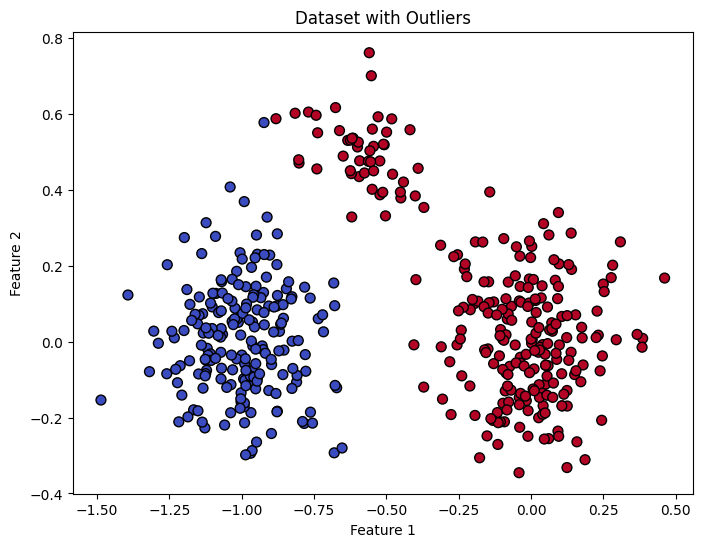

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_df_with_outliers.iloc[:, 0], X_df_with_outliers.iloc[:, 1], c=y_df_with_outliers, cmap='coolwarm', edgecolor='k', s=50)
plt.title("Dataset with Outliers")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [ ]:
def calculate_lambda(df, moc="median"):
    if moc == "median":
        center = df.median().values
    else:
        center = df.mean().values

    distances_list = []
    distances_idx_tuple_list = []

    for idx, row in df.iterrows():
        distance = np.sqrt(np.sum((row.values - center) ** 2))
        distances_list.append(distance)
        distances_idx_tuple_list.append((distance, idx))

    sorted_distances_list = sorted(distances_list)
    q1 = np.percentile(sorted_distances_list, 25)
    q3 = np.percentile(sorted_distances_list, 75)
    iqr_multiplier = (q3 - q1) * 0.75
    right_outlier_distance_bound = q3 + iqr_multiplier

    non_high_outlier_indices = [
        idx for distance, idx in distances_idx_tuple_list
        if distance <= right_outlier_distance_bound
    ]

    non_outlier_df = df.loc[non_high_outlier_indices]
    lambda_value = (1 - len(non_high_outlier_indices) / len(df)) ** (1/3)
    return non_outlier_df, lambda_value

In [ ]:
non_outlier_df, lambda_value = calculate_lambda(X_df_with_outliers, "median")
print("Computed lambda:", lambda_value)

Computed lambda: 0.36565377016217454


In [ ]:
def k_means(k, df):
  centroids = df.sample(n=k, random_state=42)
  centroids = centroids.reset_index(drop=True)
  # centroids = df[:k]

  for iteration in range(50):
    centroid_instances = [[] for n in range(k)]
    for i, df_row in df.iterrows():
      distances = []
      for j, centroid_row in centroids.iterrows():
        # DISTANCE CALCULATION
        distance = np.sqrt(np.sum((df_row.values - centroid_row.values) ** 2));
        distances.append((distance, j))

      # INSTANCE ASSIGNMENT
      min_distance, min_j = min(distances)
      centroid_instances[min_j].append(df_row)

    # CENTROID RECALCULATION
    new_centroids = pd.DataFrame()
    for cluster_id, cluster_instances in enumerate(centroid_instances):
      new_centroid = pd.DataFrame(cluster_instances).mean()
      new_centroids = pd.concat([new_centroids, new_centroid.to_frame().T], ignore_index=True)


    # STOPPING CONDITIONS
    # 1.) CENTROIDS DONT CHANGE
    # print("\n\nCENTROIDS: ", (centroids))
    # print("\n\nNEW CENTROIDS: ", (new_centroids))

    if centroids.equals(new_centroids): break

    centroids = new_centroids

  return centroid_instances, centroids

In [ ]:
def weighted_k_means(k, lambda_value, df):
  centroids = df.sample(n=k, random_state=42)
  centroids = centroids.reset_index(drop=True)
  # centroids = df[:k]

  for iteration in range(50):
    centroid_instances = [[] for n in range(k)]
    for i, df_row in df.iterrows():
      distances = []
      for j, centroid_row in centroids.iterrows():
        # DISTANCE CALCULATION
        distance = np.sqrt(np.sum((df_row.values - centroid_row.values) ** 2));
        distances.append((distance, j))

      # INSTANCE ASSIGNMENT
      min_distance, min_j = min(distances)
      centroid_instances[min_j].append(df_row)

    # CENTROID RECALCULATION
    new_centroids = pd.DataFrame()
    for cluster_id, cluster_instances in enumerate(centroid_instances):
      new_centroid_mean = pd.DataFrame(cluster_instances).mean()
      new_centroid_median = pd.DataFrame(cluster_instances).median()
      new_centroid = new_centroid_median*lambda_value+new_centroid_mean*(1-lambda_value)

      new_centroids = pd.concat([new_centroids, new_centroid.to_frame().T], ignore_index=True)


    # STOPPING CONDITIONS
    # 1.) CENTROIDS DONT CHANGE
    # print("\n\nCENTROIDS: ", (centroids))
    # print("\n\nNEW CENTROIDS: ", (new_centroids))

    if centroids.equals(new_centroids): break

    centroids = new_centroids

  return centroid_instances, centroids

In [ ]:
def calculate_cluster_homogeneity(clusters, y):
    homogeneity_list = []
    for cluster in clusters:
        cluster_labels = [y.loc[row.name] for row in cluster]
        label_counts = pd.Series(cluster_labels).value_counts()
        homogeneity_list.append(label_counts.max() / label_counts.sum())
    return homogeneity_list

In [ ]:
clusters_kmeans, centroids_kmeans = k_means(2, X_df_with_outliers)
homogeneity_kmeans = calculate_cluster_homogeneity(clusters_kmeans, y_df_with_outliers)

In [ ]:
homogeneity_kmeans

[1.0, 0.8130081300813008]

In [ ]:
clusters_weighted, centroids_weighted = weighted_k_means(2, lambda_value, X_df_with_outliers)
homogeneity_weighted = calculate_cluster_homogeneity(clusters_weighted, y_df_with_outliers)

In [ ]:
homogeneity_weighted

[1.0, 0.823045267489712]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns

In [ ]:
def assign_labels_to_clusters(clusters, y):
    cluster_labels = {}
    assigned_labels = []
    for cluster_id, cluster in enumerate(clusters):
        cluster_indices = [row.name for row in cluster]
        cluster_true_labels = y.loc[cluster_indices]
        most_common_label = cluster_true_labels.value_counts().idxmax()
        cluster_labels[cluster_id] = most_common_label
        for row in cluster: assigned_labels.append((row.name, most_common_label))
    assigned_labels.sort()
    return [label for _, label in assigned_labels]

In [ ]:
y_pred_kmeans = assign_labels_to_clusters(clusters_kmeans, y_df_with_outliers)
y_pred_weighted = assign_labels_to_clusters(clusters_weighted, y_df_with_outliers)

In [ ]:
precision_kmeans = precision_score(y_df_with_outliers, y_pred_kmeans, average='macro')
recall_kmeans = recall_score(y_df_with_outliers, y_pred_kmeans, average='macro')
f1_kmeans = f1_score(y_df_with_outliers, y_pred_kmeans, average='macro')
accuracy_kmeans = accuracy_score(y_df_with_outliers, y_pred_kmeans)
conf_matrix_kmeans = confusion_matrix(y_df_with_outliers, y_pred_kmeans)

In [ ]:
print("K-means:")
print(f"Precision: {precision_kmeans:.4f}")
print(f"Recall: {recall_kmeans:.4f}")
print(f"F1-Score: {f1_kmeans:.4f}")
print(f"Accuracy: {accuracy_kmeans:.4f}")

K-means:
Precision: 0.9065
Recall: 0.9080
F1-Score: 0.8978
Accuracy: 0.8978


In [ ]:
precision_weighted = precision_score(y_df_with_outliers, y_pred_weighted, average='macro')
recall_weighted = recall_score(y_df_with_outliers, y_pred_weighted, average='macro')
f1_weighted = f1_score(y_df_with_outliers, y_pred_weighted, average='macro')
accuracy_weighted = accuracy_score(y_df_with_outliers, y_pred_weighted)
conf_matrix_weighted = confusion_matrix(y_df_with_outliers, y_pred_weighted)

In [ ]:
print("Weighted K-Means:")
print(f"Precision: {precision_weighted:.4f}")
print(f"Recall: {recall_weighted:.4f}")
print(f"F1-Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy_weighted:.4f}")

Weighted K-Means:
Precision: 0.9115
Recall: 0.9140
F1-Score: 0.9044
Accuracy: 0.9044


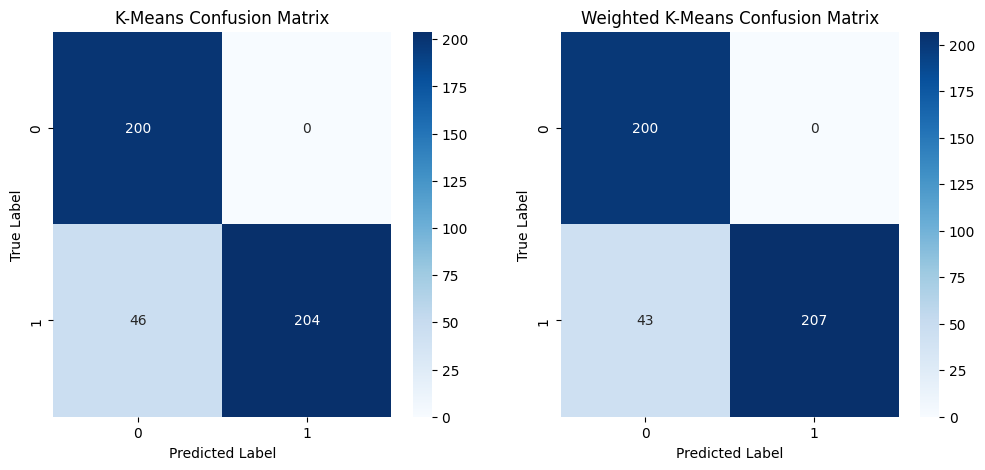

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(conf_matrix_kmeans, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("K-Means Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")
sns.heatmap(conf_matrix_weighted, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("Weighted K-Means Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")
plt.show()